Lets start with modelling with the given data, for following targets:
1. financial and risk forecasting
2. ideal customer profile (ICP)

## Financial and Risk Forecasting

Data Preparation:

In [66]:
!pip install lazypredict
!pip install flaml

In [67]:
import pandas as pd
import numpy as np
from scipy import stats
from tabulate import tabulate
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from sklearn.model_selection import train_test_split
from flaml import AutoML
import lazypredict
from lazypredict.Supervised import LazyClassifier, LazyRegressor
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, StandardScaler


filepath = "/content/insurance_data_sample.csv"
df = pd.read_csv(filepath)

#Converting Date column to pd.date format
df['Date'] = pd.to_datetime(df['Date'])
df['Year'] = df['Date'].dt.year
df['Month'] = df['Date'].dt.month
df['Day'] = df['Date'].dt.day
df.drop(columns=[ 'Date'], inplace= True)
print(tabulate(df.head(10), headers = df.columns, tablefmt = 'psql'))



+----+--------------+-----------------+----------+-----------------+-------------------------------------+------------+------------+-----------------------------+----------------+------------+-------------+--------------+--------------+---------+-----------------------------+----------------+-----------+--------+---------+-------+
|    | Car_id       | Customer Name   | Gender   |   Annual Income | Dealer_Name                         | Company    | Model      | Engine                      | Transmission   | Color      |   Price ($) | Dealer_No    | Body Style   |   Phone |   Amount_paid_for_insurance |   Claim amount | City      |   Year |   Month |   Day |
|----+--------------+-----------------+----------+-----------------+-------------------------------------+------------+------------+-----------------------------+----------------+------------+-------------+--------------+--------------+---------+-----------------------------+----------------+-----------+--------+---------+-------|
|

In [68]:
# removving irrelevant columns
df.drop(["Car_id", "Phone", "Customer Name"], axis=1, inplace=True)

# lets convert the datatype to category to save space and efficiency
cat_var = ['Gender', 'Dealer_Name', 'Company', 'Model', 'Engine', 'Transmission', 'Color', 'Dealer_No ', 'Body Style', 'City']
for cat in cat_var:
    df[cat] = df[cat].astype("category")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23906 entries, 0 to 23905
Data columns (total 17 columns):
 #   Column                     Non-Null Count  Dtype   
---  ------                     --------------  -----   
 0   Gender                     23906 non-null  category
 1   Annual Income              23906 non-null  int64   
 2   Dealer_Name                23906 non-null  category
 3   Company                    23906 non-null  category
 4   Model                      23906 non-null  category
 5   Engine                     23906 non-null  category
 6   Transmission               23906 non-null  category
 7   Color                      23906 non-null  category
 8   Price ($)                  23906 non-null  int64   
 9   Dealer_No                  23906 non-null  category
 10  Body Style                 23906 non-null  category
 11  Amount_paid_for_insurance  23906 non-null  int64   
 12  Claim amount               23906 non-null  float64 
 13  City                       2390

In [69]:

# function to detect outliers using the IQR method
def detect_outliers_iqr(df):
    numerical_cols = df.columns[df.dtypes.apply(lambda x: x in [int, float])]
    outliers = pd.DataFrame(columns=['Column', 'Outliers', 'Percentage'])
    outliers_list = []
    for col in numerical_cols:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)  # Changed from 0.80 to 0.75 (standard IQR)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        outlier_count = ((df[col] < lower_bound) | (df[col] > upper_bound)).sum()
        outlier_percentage = (outlier_count / df[col].shape[0]) * 100
        outliers_list.append({'Column': col, 'Outliers': outlier_count, 'Percentage': outlier_percentage})
    outliers = pd.DataFrame(outliers_list)
    return outliers

# a function detecting outliers using the z-score method
def detect_outliers_zscore(df, threshold=3):
    numerical_cols = df.columns[df.dtypes.apply(lambda x: x in [int, float])]
    outliers = pd.DataFrame(columns=['Column', 'Outliers', 'Percentage'])
    outliers_list = []
    for col in numerical_cols:
        z_scores = ((df[col] - df[col].mean()) / df[col].std()).abs()
        outlier_count = (z_scores > threshold).sum()
        outlier_percentage = (outlier_count / df[col].shape[0]) * 100
        outliers_list.append({'Column': col, 'Outliers': outlier_count, 'Percentage': outlier_percentage})
    outliers = pd.DataFrame(outliers_list)
    return outliers

In [70]:
# Clean the data by handling missing values, outliers, and inconsistencies.
print ("\nMissing values :  ", df.isnull().sum().values.sum())

# Detect outliers using the IQR method
outliers_iqr = detect_outliers_iqr(df)
print("Outliers using IQR method:")
print(outliers_iqr)

# Detect outliers using the z-score method
outliers_zscore = detect_outliers_zscore(df)
print("\nOutliers using z-score method (threshold=3):")
print(outliers_zscore)


Missing values :   0
Outliers using IQR method:
                      Column  Outliers  Percentage
0              Annual Income       816        3.41
1                  Price ($)      1449        6.06
2  Amount_paid_for_insurance      1232        5.15
3               Claim amount      2390       10.00

Outliers using z-score method (threshold=3):
                      Column  Outliers  Percentage
0              Annual Income       336        1.41
1                  Price ($)       351        1.47
2  Amount_paid_for_insurance       383        1.60
3               Claim amount       662        2.77


In [71]:
print("Shape of DataFrame before removing outliers:", df.shape)

# Columns to remove outliers from
columns_to_remove_outliers = ['Annual Income', 'Price ($)']

# Define a function to remove outliers using z-score method
def remove_outliers_zscore(df, columns):
    for col in columns:
        z_scores = stats.zscore(df[col])
        df = df[(z_scores < 1.4) & (z_scores > -1.4)]
    return df

# Remove outliers from specified columns
df = remove_outliers_zscore(df, columns_to_remove_outliers)

# Display shape of DataFrame before and after removing outliers
print("Shape of DataFrame after removing outliers:", df.shape)

Shape of DataFrame before removing outliers: (23906, 17)
Shape of DataFrame after removing outliers: (19944, 17)


In [72]:
# Checking datatypes of columns
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 19944 entries, 0 to 23905
Data columns (total 17 columns):
 #   Column                     Non-Null Count  Dtype   
---  ------                     --------------  -----   
 0   Gender                     19944 non-null  category
 1   Annual Income              19944 non-null  int64   
 2   Dealer_Name                19944 non-null  category
 3   Company                    19944 non-null  category
 4   Model                      19944 non-null  category
 5   Engine                     19944 non-null  category
 6   Transmission               19944 non-null  category
 7   Color                      19944 non-null  category
 8   Price ($)                  19944 non-null  int64   
 9   Dealer_No                  19944 non-null  category
 10  Body Style                 19944 non-null  category
 11  Amount_paid_for_insurance  19944 non-null  int64   
 12  Claim amount               19944 non-null  float64 
 13  City                       19944 non

### Fearture selection

In [73]:
from scipy.stats import f_oneway
# Select only the categorical features
categorical_features = df.select_dtypes(include=['category']).columns

# Perform ANOVA for each categorical feature
anova_results = {}
for feature in categorical_features:
    groups = df.groupby(feature)['Claim amount'].apply(list)
    anova_result = f_oneway(*groups)
    anova_results[feature] = anova_result

# Display ANOVA results
for feature, result in anova_results.items():
    print(f"ANOVA for {feature}: F-statistic={result.statistic:.4f}, p-value={result.pvalue:.4f}")

ANOVA for Gender: F-statistic=0.0047, p-value=0.9456
ANOVA for Dealer_Name: F-statistic=0.9201, p-value=0.5833
ANOVA for Company: F-statistic=1.3835, p-value=0.0822
ANOVA for Model: F-statistic=1.3194, p-value=0.0051
ANOVA for Engine: F-statistic=0.4657, p-value=0.4950
ANOVA for Transmission: F-statistic=0.4657, p-value=0.4950
ANOVA for Color: F-statistic=1.3689, p-value=0.2544
ANOVA for Dealer_No : F-statistic=0.2969, p-value=0.9387
ANOVA for Body Style: F-statistic=1.3040, p-value=0.2659
ANOVA for City: F-statistic=0.7533, p-value=0.5835


Now, interpreting the results:

1. **Gender**: The F-statistic is low, and the p-value is high (close to 1). This suggests that there is no significant difference in claim amounts across different genders.

2. **Dealer_Name**: The F-statistic is relatively high, but the p-value is not low enough to reject the null hypothesis. It indicates that there is no significant difference in claim amounts across different dealers.

3. **Company**: The F-statistic is moderate, but the p-value is relatively high (above the typical significance level of 0.05). This suggests that there is no significant difference in claim amounts across different companies.

4. **Model**: The F-statistic is moderate, and the p-value is low (below the typical significance level). This suggests that there may be a significant difference in claim amounts across different models.

5. **Engine** and **Transmission**: Both have similar F-statistics and p-values. They indicate that there is no significant difference in claim amounts across different engine types or transmission types.

6. **Color**: The F-statistic is moderate, but the p-value is relatively high. This suggests that there is no significant difference in claim amounts across different colors.

7. **Dealer_No**: The F-statistic is low, and the p-value is high. This suggests that there is no significant difference in claim amounts across different dealer numbers.

8. **Body Style**: The F-statistic is moderate, but the p-value is relatively high. This suggests that there is no significant difference in claim amounts across different body styles.

9. **City**: The F-statistic is low, and the p-value is high. This suggests that there is no significant difference in claim amounts across different cities.


We will exclude the following categories
1. Dealer_No: p-value = 0.9387
2. Gender: p-value = 0.9456

In [74]:
df.drop(columns=["Dealer_No ", "Gender"], axis=1, inplace=True)

### numerical correlations

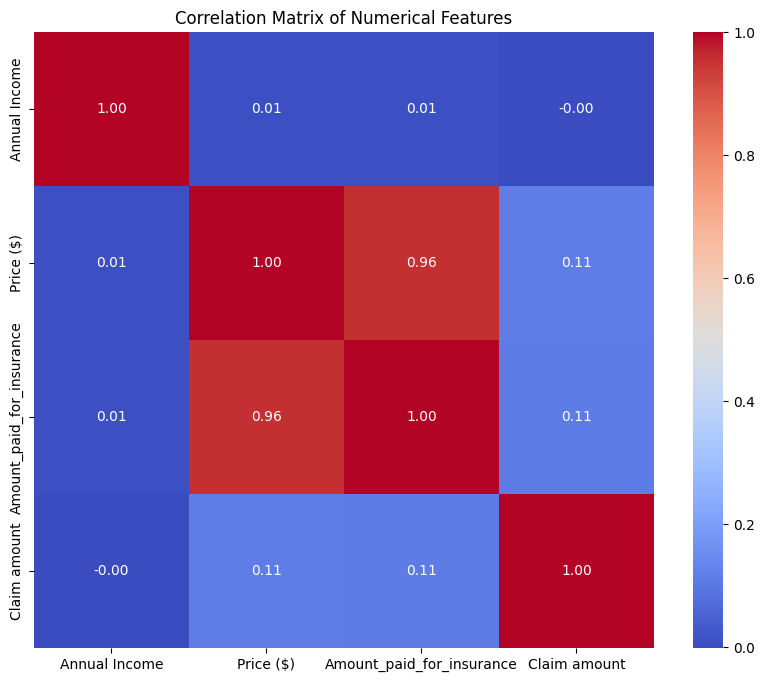

Correlation Matrix:
                           Annual Income  Price ($)  \
Annual Income                       1.00       0.01   
Price ($)                           0.01       1.00   
Amount_paid_for_insurance           0.01       0.96   
Claim amount                       -0.00       0.11   

                           Amount_paid_for_insurance  Claim amount  
Annual Income                                   0.01         -0.00  
Price ($)                                       0.96          0.11  
Amount_paid_for_insurance                       1.00          0.11  
Claim amount                                    0.11          1.00  

Highly Correlated Features:
                           Annual Income  Price ($)  \
Annual Income                       1.00        NaN   
Price ($)                            NaN       1.00   
Amount_paid_for_insurance            NaN       0.96   
Claim amount                         NaN        NaN   

                           Amount_paid_for_insurance  

In [75]:
corr_matrix = df.select_dtypes(include=['int64', 'float64']).corr()

# Plot the correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix of Numerical Features')
plt.show()

# Display the correlation matrix
print("Correlation Matrix:")
print(corr_matrix)

# Identify highly correlated features (correlation > 0.75 or < -0.75)
high_corr_features = corr_matrix[(corr_matrix > 0.75) | (corr_matrix < -0.75)]
print("\nHighly Correlated Features:")
print(high_corr_features)

Upon observation, we see `Price ($)` and Amount_paid_for_insurance with a correlation of 0.955822.So we need to drop one.
We drop Price ($).

In [76]:
# dropping highly correlated column 'Price ($)'
df = df.drop(columns=['Price ($)'])
df.head()

,Annual Income,Dealer_Name,Company,Model,Engine,Transmission,Color,Body Style,Amount_paid_for_insurance,Claim amount,City,Year,Month,Day
0,13500,Buddy Storbeck's Diesel Service Inc,Ford,Expedition,DoubleÃ‚Â Overhead Camshaft,Auto,Black,SUV,1665,0.00,Riga,2022,1,2
1,1480000,C & M Motors Inc,Dodge,Durango,DoubleÃ‚Â Overhead Camshaft,Auto,Black,SUV,1332,1900.00,Liepaja,2022,1,2
2,1035000,Capitol KIA,Cadillac,Eldorado,Overhead Camshaft,Manual,Red,Passenger,1897,0.00,Riga,2022,1,2
3,13500,Chrysler of Tri-Cities,Toyota,Celica,Overhead Camshaft,Manual,Pale White,SUV,1176,0.00,Jelgava,2022,1,2
4,1465000,Chrysler Plymouth,Acura,TL,DoubleÃ‚Â Overhead Camshaft,Auto,Red,Hatchback,1323,2450.00,Liepaja,2022,1,2


Lets encode the categorical columns

In [77]:
# Encode categorical features
categorical_features = df.select_dtypes(include=['category']).columns
label_encoder = LabelEncoder()
for col in categorical_features:
    df[col] = label_encoder.fit_transform(df[col])
df.head()

,Annual Income,Dealer_Name,Company,Model,Engine,Transmission,Color,Body Style,Amount_paid_for_insurance,Claim amount,City,Year,Month,Day
0,13500,0,8,60,0,0,0,3,1665,0.00,3,2022,1,2
1,1480000,1,7,52,0,0,0,3,1332,1900.00,2,2022,1,2
2,1035000,2,4,57,1,1,2,2,1897,0.00,3,2022,1,2
3,13500,4,27,36,1,1,1,3,1176,0.00,1,2022,1,2
4,1465000,3,0,141,0,0,2,1,1323,2450.00,2,2022,1,2


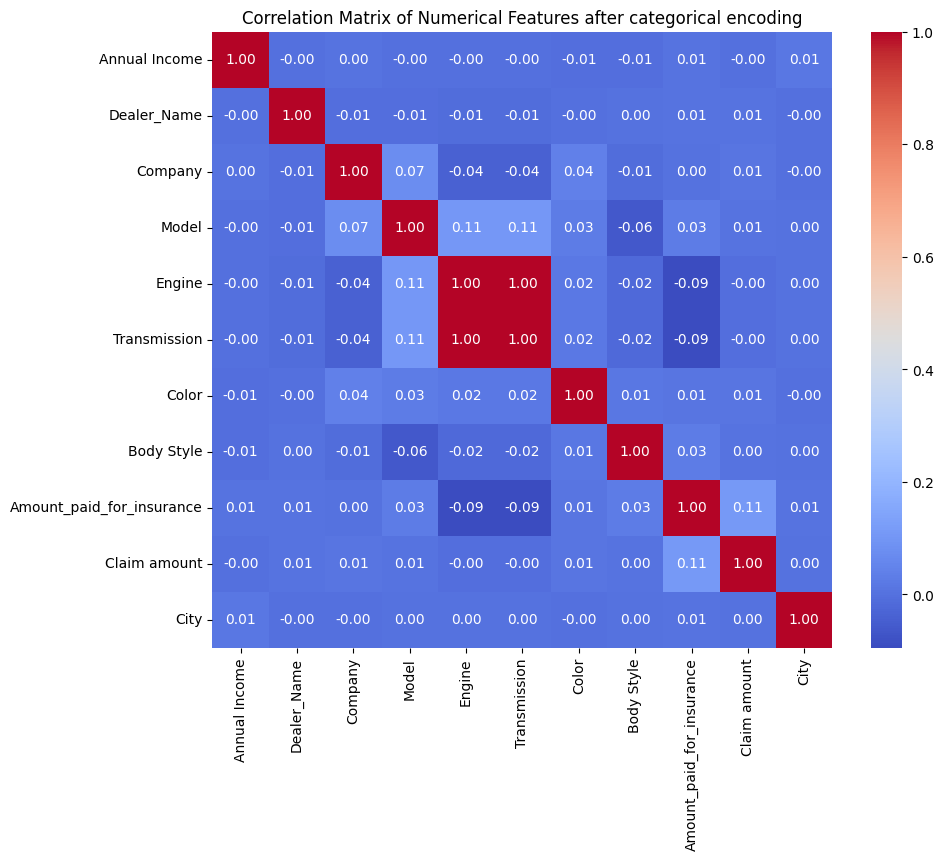

Correlation Matrix:
                           Annual Income  Dealer_Name  Company  Model  Engine  \
Annual Income                       1.00        -0.00     0.00  -0.00   -0.00   
Dealer_Name                        -0.00         1.00    -0.01  -0.01   -0.01   
Company                             0.00        -0.01     1.00   0.07   -0.04   
Model                              -0.00        -0.01     0.07   1.00    0.11   
Engine                             -0.00        -0.01    -0.04   0.11    1.00   
Transmission                       -0.00        -0.01    -0.04   0.11    1.00   
Color                              -0.01        -0.00     0.04   0.03    0.02   
Body Style                         -0.01         0.00    -0.01  -0.06   -0.02   
Amount_paid_for_insurance           0.01         0.01     0.00   0.03   -0.09   
Claim amount                       -0.00         0.01     0.01   0.01   -0.00   
City                                0.01        -0.00    -0.00   0.00    0.00   

       

In [78]:
# lets check correlation matrix again

corr_matrix = df.select_dtypes(include=['int64', 'float64']).corr()

# Plot the correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix of Numerical Features after categorical encoding')
plt.show()

# Display the correlation matrix
print("Correlation Matrix:")
print(corr_matrix)

# Identify highly correlated features (correlation > 0.75 or < -0.75)
high_corr_features = corr_matrix[(corr_matrix > 0.75) | (corr_matrix < -0.75)]
print("\nHighly Correlated Features:")
print(high_corr_features)

In [79]:
# train-test split
X = df.drop(columns=['Claim amount'])
y = df['Claim amount']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [80]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 15955 entries, 13279 to 19008
Data columns (total 13 columns):
 #   Column                     Non-Null Count  Dtype
---  ------                     --------------  -----
 0   Annual Income              15955 non-null  int64
 1   Dealer_Name                15955 non-null  int64
 2   Company                    15955 non-null  int64
 3   Model                      15955 non-null  int64
 4   Engine                     15955 non-null  int64
 5   Transmission               15955 non-null  int64
 6   Color                      15955 non-null  int64
 7   Body Style                 15955 non-null  int64
 8   Amount_paid_for_insurance  15955 non-null  int64
 9   City                       15955 non-null  int64
 10  Year                       15955 non-null  int32
 11  Month                      15955 non-null  int32
 12  Day                        15955 non-null  int32
dtypes: int32(3), int64(10)
memory usage: 1.5 MB


In [81]:
# scaling/normalization (example: StandardScaler)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
X_train_scaled.shape, y_train.shape

((15955, 13), (15955,))

### Using Lazypredict for baseline testings

### Regression

In [82]:
reg = LazyRegressor(verbose=0,ignore_warnings=False, custom_metric=None )
models,predictions = reg.fit(X_train, X_test, y_train, y_test)


 21%|██▏       | 9/42 [00:05<00:36,  1.09s/it]

GammaRegressor model failed to execute
Some value(s) of y are out of the valid range of the loss 'HalfGammaLoss'.


 79%|███████▊  | 33/42 [21:50<08:37, 57.46s/it]

QuantileRegressor model failed to execute
Solver interior-point is not anymore available in SciPy >= 1.11.0.


 98%|█████████▊| 41/42 [22:30<00:15, 15.18s/it]

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001523 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 796
[LightGBM] [Info] Number of data points in the train set: 15955, number of used features: 13
[LightGBM] [Info] Start training from score 242.077154


100%|██████████| 42/42 [22:30<00:00, 32.16s/it]


### Classifier

In [83]:
# Convert zeros to 0 and non-zeros to 1
y_train_binary = (y_train != 0).astype(int)
y_test_binary = (y_test != 0).astype(int)

# Print to verify
print("y_train_binary:", y_train_binary)
print("y_target_binary:", y_test_binary)


y_train_binary: 13279    0
5320     0
4793     0
6143     0
19568    0
        ..
13616    1
14466    0
6575     0
1040     0
19008    0
Name: Claim amount, Length: 15955, dtype: int64
y_target_binary: 2806     0
16935    0
4657     0
5804     0
11885    0
        ..
1586     0
13659    0
15858    1
18454    0
8262     0
Name: Claim amount, Length: 3989, dtype: int64


In [84]:
clf = LazyClassifier(verbose=0,ignore_warnings=True, custom_metric=None)
models,predictions = clf.fit(X_train, X_test, y_train_binary, y_test_binary)
models

100%|██████████| 29/29 [01:18<00:00,  2.70s/it]

[LightGBM] [Info] Number of positive: 1594, number of negative: 14361
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000784 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 796
[LightGBM] [Info] Number of data points in the train set: 15955, number of used features: 13
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.099906 -> initscore=-2.198270
[LightGBM] [Info] Start training from score -2.198270


,Accuracy,Balanced Accuracy,ROC AUC,F1 Score,Time Taken
Model,,,,,
PassiveAggressiveClassifier,0.73,0.52,0.52,0.77,0.07
KNeighborsClassifier,0.90,0.50,0.50,0.86,1.36
BaggingClassifier,0.90,0.50,0.50,0.86,1.18
XGBClassifier,0.90,0.50,0.50,0.86,0.27
QuadraticDiscriminantAnalysis,0.90,0.50,0.50,0.86,0.06
DecisionTreeClassifier,0.80,0.50,0.50,0.81,0.20
AdaBoostClassifier,0.90,0.50,0.50,0.86,1.07
SVC,0.90,0.50,0.50,0.86,26.54
SGDClassifier,0.90,0.50,0.50,0.86,0.11


The above table presents the performance of various classification models on a dataset, evaluating them based on Accuracy, Balanced Accuracy, ROC AUC, F1 Score, and Time Taken. Here's a summary of the key findings:

**Top Performers:**

Several models achieved an accuracy of 0.90, indicating that they correctly classified 90% of the samples in the dataset. These top performers include:

- KNeighborsClassifier
- BaggingClassifier
- XGBClassifier
- QuadraticDiscriminantAnalysis
- AdaBoostClassifier
- SVC
- SGDClassifier
- RidgeClassifierCV
- RidgeClassifier
- RandomForestClassifier
- LogisticRegression
- LinearSVC
- LinearDiscriminantAnalysis
- GaussianNB
- DummyClassifier
- CalibratedClassifierCV
- BernoulliNB
- LGBMClassifier
- ExtraTreesClassifier

However, the balanced accuracy and ROC AUC for these models are only 0.50, suggesting that they may not perform equally well across all classes, especially if the dataset is imbalanced.

**Models with Lower Accuracy:**

- PassiveAggressiveClassifier (0.73 accuracy)
- DecisionTreeClassifier (0.80 accuracy)
- LabelSpreading (0.82 accuracy)
- LabelPropagation (0.82 accuracy)
- ExtraTreeClassifier (0.81 accuracy)
- NearestCentroid (0.51 accuracy)
- Perceptron (0.73 accuracy)

These models might be less suitable for the given dataset, either due to their inherent limitations or because they require further tuning or feature engineering.

**F1 Score:**

The F1 score, which balances precision and recall, is highest for PassiveAggressiveClassifier and Perceptron (0.77). This indicates that these models might be better at identifying positive cases (high recall) even at the cost of some false positives (lower precision).

**Time Taken:**

SVC and LabelSpreading are the most computationally expensive models, taking 26.54 and 22.71 seconds respectively. This could be a limiting factor if real-time predictions are required.

**Overall:**

While many models achieve high accuracy, their poor balanced accuracy and ROC AUC suggest potential issues with class imbalance. It's crucial to consider the specific requirements of the task at hand and choose a model that not only performs well overall but also addresses the class imbalance effectively.

Additionally, the computational cost of some models should be considered, especially for applications with real-time constraints.


In [85]:
# Convert zeros to 0 and non-zeros to 1
y_train_binary = (y_train != 0).astype(int)
y_test_binary = (y_test != 0).astype(int)

# Print to verify
print("y_train_binary:", y_train_binary)
print("y_target_binary:", y_test_binary)


y_train_binary: 13279    0
5320     0
4793     0
6143     0
19568    0
        ..
13616    1
14466    0
6575     0
1040     0
19008    0
Name: Claim amount, Length: 15955, dtype: int64
y_target_binary: 2806     0
16935    0
4657     0
5804     0
11885    0
        ..
1586     0
13659    0
15858    1
18454    0
8262     0
Name: Claim amount, Length: 3989, dtype: int64


In [86]:
clf = LazyClassifier(verbose=0,ignore_warnings=True, custom_metric=None)
models,predictions = clf.fit(X_train, X_test, y_train_binary, y_test_binary)
models

100%|██████████| 29/29 [01:21<00:00,  2.83s/it]

[LightGBM] [Info] Number of positive: 1594, number of negative: 14361
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000775 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 796
[LightGBM] [Info] Number of data points in the train set: 15955, number of used features: 13
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.099906 -> initscore=-2.198270
[LightGBM] [Info] Start training from score -2.198270


,Accuracy,Balanced Accuracy,ROC AUC,F1 Score,Time Taken
Model,,,,,
PassiveAggressiveClassifier,0.73,0.52,0.52,0.77,0.06
KNeighborsClassifier,0.90,0.50,0.50,0.86,1.36
BaggingClassifier,0.90,0.50,0.50,0.86,1.60
XGBClassifier,0.90,0.50,0.50,0.86,0.27
QuadraticDiscriminantAnalysis,0.90,0.50,0.50,0.86,0.05
DecisionTreeClassifier,0.80,0.50,0.50,0.81,0.19
AdaBoostClassifier,0.90,0.50,0.50,0.86,1.22
SVC,0.90,0.50,0.50,0.86,26.01
SGDClassifier,0.90,0.50,0.50,0.86,0.13
